# Training Data Generation

The input images will be cut randomly into smaller pieces to train the neural network.

Press 'Run' (above) or Shift+Enter.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
import os
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui tk

from tifffile import imread
from tkinter import filedialog, simpledialog
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.data import RawData, create_patches
from csbdeep.io import load_training_data, load_training_data_direct
from csbdeep.models import Config, CARE
from IPython.display import clear_output

root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

# Ask for folder path
directory = filedialog.askdirectory(title="Choose big folder directory")

# Look for first tif file
for file in os.scandir(directory + '/HighRes/'):
    if file.name.endswith(".tif"):
        break

# Open tif file
y = imread(directory + '/HighRes/' + file.name)
x = imread(directory + '/LowRes1/' + file.name)

print('Showing ' + file.name)
print('Image size =', x.shape)
chan = x.shape[1]

if chan > 2:
    chanplt = 2
else:
    chanplt = chan
    
plt.figure(figsize=(16,10))
plot_some(np.stack([np.moveaxis(x,1,-1)[5,:,:,0:chanplt],np.moveaxis(y,1,-1)[5,:,:,0:chanplt]]),
          title_list=[['Low','Ground Truth']], 
          pmin=2,pmax=99.8);

modelname = None;

Using TensorFlow backend.


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/HighRes/'

Creating patches


c:\users\user\appdata\local\conda\conda\envs\tf-gpu\lib\site-packages\csbdeep\data\generate.py:300: RuntimeWarning: overflow encountered in long_scalars
  n_required_memory_bytes = np.uint64(2 * n_patches*np.prod(patch_size) * 4)


  498 raw images x    1 transformations   =   498 images
  498 images     x  256 patches per image = 127488 patches in total
Input data:
G:/Fra: target='G:/Fra/HighRes', sources=['LowRes1', 'LowRes2', 'LowRes3'], axes='ZCYX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
8 x 2 x 96 x 96


100%|████████████████████████████████████████████████████████████████████████████████| 498/498 [12:35<00:00,  1.54s/it]


Augmenting: flip round 1


100%|████████████████████████████████████████████████████████████████████████| 127488/127488 [00:33<00:00, 3849.77it/s]


Augmenting: rotate


100%|████████████████████████████████████████████████████████████████████████| 127488/127488 [00:50<00:00, 2529.47it/s]


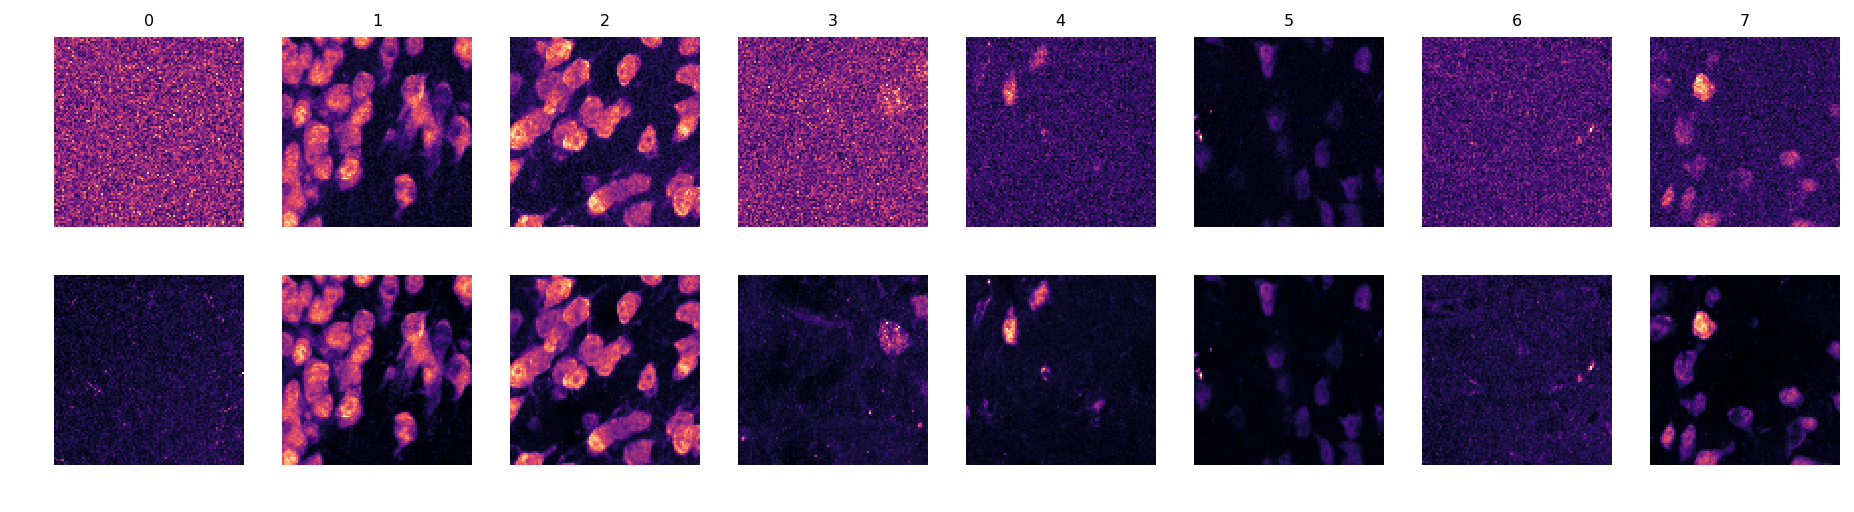

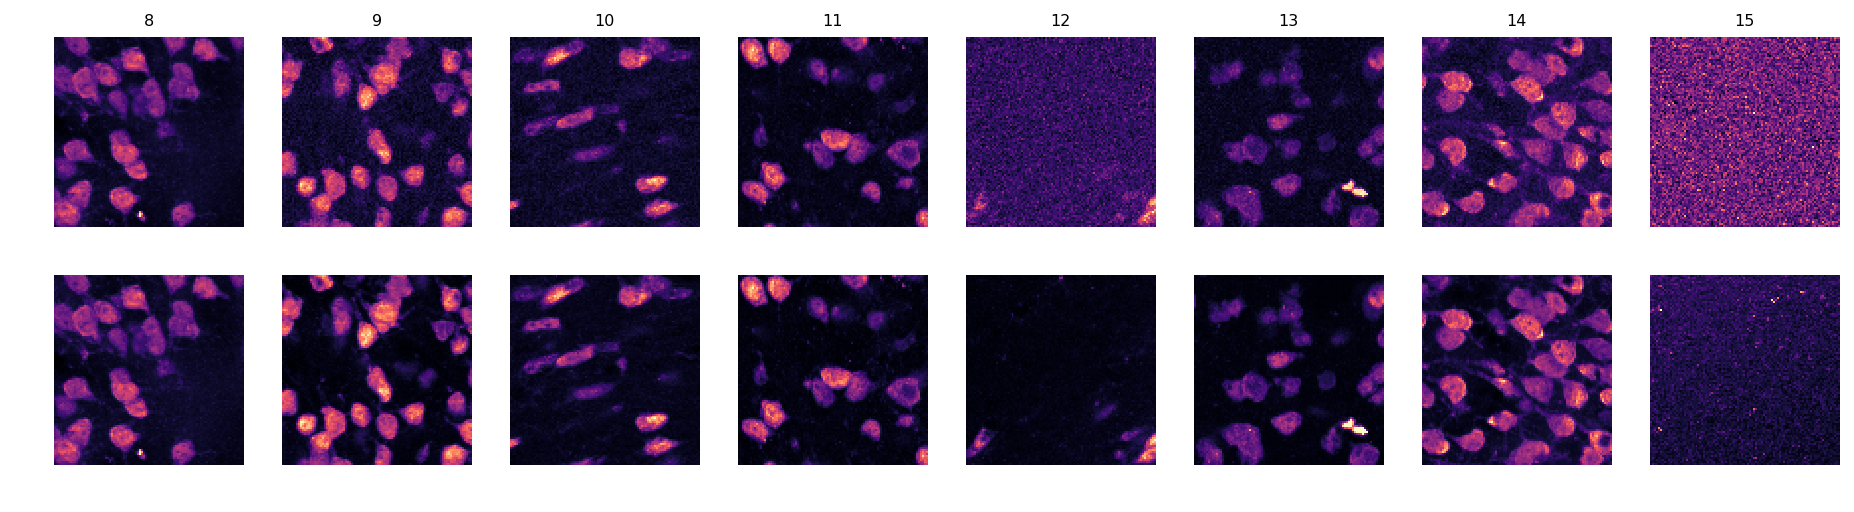

NameError: name 'm' is not defined

In [4]:
# If images match, then run this cell.
if modelname == None:
    modelname = list()
    for i in range(chan):
        modelname.append(simpledialog.askstring("Input", "Model name for channel " + str(i+1) + "?", parent=root))

print("Creating patches")

raw_data = RawData.from_folder(
    basepath=directory,
    source_dirs=['LowRes1', 'LowRes2', 'LowRes3'],
    target_dir=directory + '/HighRes',
    axes='ZCYX')

X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (8,chan,96,96),
    n_patches_per_image = 256,
)

# Two random flips
from tqdm import tqdm
for i in range(1):
    print("Augmenting: flip round " + str(i+1))
    for j in tqdm(range(X.shape[0])):
        n = random.randint(0,3)
        if n == 0: # Do nothing
            pass
        else:
            X[j] = np.flip(X[j], n)
            Y[j] = np.flip(Y[j], n)

print("Augmenting: rotate")
for i in tqdm(range(X.shape[0])):
    n = random.randint(0,3)
    if n == 0: # Do nothing
        pass
    else:
        X[i] = np.rot90(X[i], n, (2,3))
        Y[i] = np.rot90(Y[i], n, (2,3))

for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;

for i in range(chan):
    print("Training channel " + str(i+1))
    (Xchan,Ychan), (X_val,Y_val), axes = load_training_data_direct(
        X[:,i,:,:].reshape((X.shape[0],1,X.shape[2],X.shape[3],X.shape[4])),
        Y[:,i,:,:].reshape((Y.shape[0],1,Y.shape[2],Y.shape[3],Y.shape[4])),
        validation_split=0.01, verbose=True, axes='SCZYX')
    
    c = axes_dict(axes)['C']
    config = Config(axes, n_channel_in=Xchan.shape[c], n_channel_out=Ychan.shape[c],
                    train_steps_per_epoch=100, 
                    unet_n_depth=3, u_net_n_first=32, train_batch_size=32,
                    train_learning_rate=0.0008, train_epochs=40,
                    train_reduce_lr={'factor':0.5, 'patience': 3, 'min_delta':0})
    # print(config)
    
    vars(config)
    model = CARE(config, modelname[i], basedir='models')

    history = model.train(Xchan,Ychan, validation_data=(X_val,Y_val))
    clear_output()

Check that the image pairing matches.

Please input the model name in the cell below. The models are saved locally in <i>My Documents/csbdeep/models</i>.

<b>Be aware that the code will overwrite any existing model with the same name.</b>

Run the cell below to start training. Aim to train until the 'ReduceLROnPlateau' command shows up 3 times. Press the stop button to stop the training at any point.

## And you're done!

Don't forget the to shutdown this file before running something else.